### Import required packages

In [1]:
#python and matplotlib libraries
import numpy as np
import math 
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec

#geospatial libraries
import rasterio
import fiona
import geopandas as gpd

#machine learning libraries
#↓!pip install scikit-image
from skimage import feature
#from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import probabilistic_hough_line

### Import raster and read band

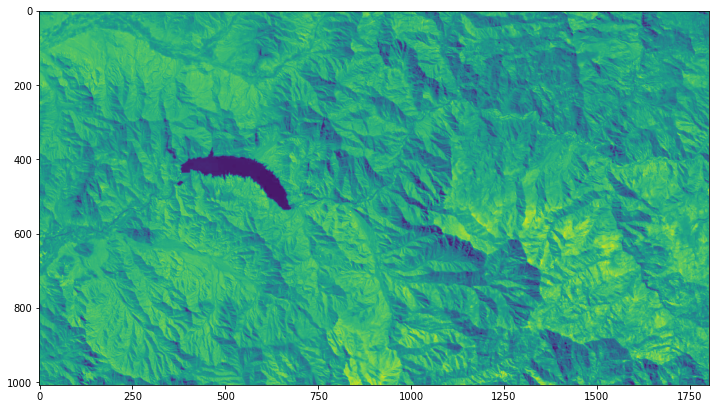

In [2]:
#imgRaster = rasterio.open('../Rst/CREC_Corn_P4P_Clip2.tif')
imgRaster = rasterio.open('../Rst/landsatImage.tif')
im = imgRaster.read(1)
fig = plt.figure(figsize=(12,8))
plt.imshow(im)
plt.show()

### Canny filter

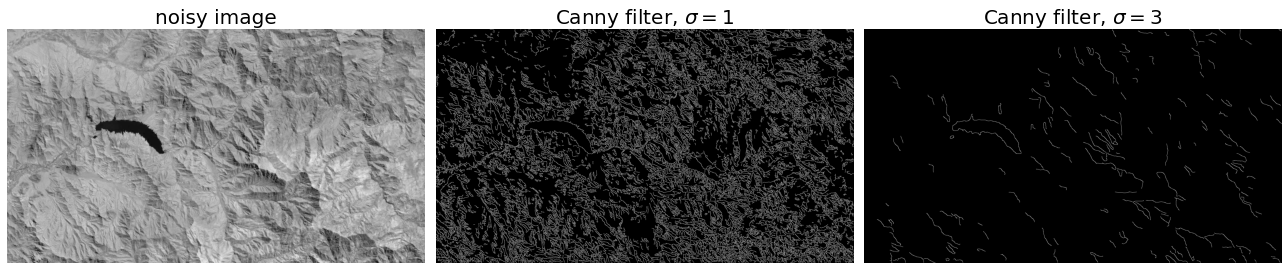

In [3]:
# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Hough line transform

In [5]:
selImage = edges2

# Classic straight-line Hough transform
# Set a precision of 2 degree.

precision = 2

#tested_angles = np.linspace(-np.pi / 2, np.pi / 2, int(180 / precision), endpoint=False)
lines = probabilistic_hough_line(selImage, threshold=10, line_length=5, line_gap=3)
#h, theta, d = hough_line(selImage, theta=tested_angles)
#lines


In [26]:
rasterOut = rasterio.open(
    '/Rst/landsatImage_edges.tif',
    'w',
    driver='GTiff',
    height=edges2.shape[0],
    width=edges2.shape[1],
    count=1.
    dtype=edges2.dtype.
    crs=im)

Signature:
probabilistic_hough_line(
    image,
    threshold=10,
    line_length=50,
    line_gap=10,
    theta=None,
    seed=None,
)
Docstring:
Return lines from a progressive probabilistic line Hough transform.

Parameters
----------
image : (M, N) ndarray
    Input image with nonzero values representing edges.
threshold : int, optional
    Threshold
line_length : int, optional
    Minimum accepted length of detected lines.
    Increase the parameter to extract longer lines.
line_gap : int, optional
    Maximum gap between pixels to still form a line.
    Increase the parameter to merge broken lines more aggressively.
theta : 1D ndarray, dtype=double, optional
    Angles at which to compute the transform, in radians.
    If None, use a range from -pi/2 to pi/2.
seed : int, optional
    Seed to initialize the random number generator.

Returns
-------
lines : list
  List of lines identified, lines in format ((x0, y0), (x1, y1)),
  indicating line start and end.

References
----------

In [25]:
lines[:5]

[((1367, 894), (1358, 885)),
 ((799, 326), (792, 319)),
 ((1126, 610), (1118, 607)),
 ((1027, 156), (1019, 145)),
 ((814, 342), (805, 333))]

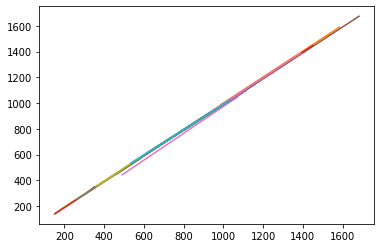

In [27]:
for index, reach in enumerate(lines[:20]):
    plt.plot(reach[0],reach[1])

### Transform results to geospatial information

In [ ]:
#define representative length of interpreted lines in pixels
#selDiag = int(np.sqrt(selImage.shape[0]**2+selImage.shape[1]**2))
selDiag = selImage.shape[1]
progRange = range(selDiag)

In [ ]:
# Generating figure 1
fig = plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(2,2)

ax0 = plt.subplot(gs[0,0])
ax0.imshow(selImage, cmap=cm.YlGnBu)
ax0.set_title('Input image')
ax0.set_axis_off()

ax1 = plt.subplot(gs[:,1])
angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]
ax1.imshow(np.log(1 + h), extent=bounds, cmap=cm.YlGn, aspect=1 / 1.5)
ax1.set_title('Hough transform')
ax1.set_xlabel('Angles (degrees)')
ax1.set_ylabel('Distance (pixels)')
ax1.axis('image')
ax1.set_aspect(.2)

ax2 = plt.subplot(gs[1,0])
ax2.imshow(selImage, cmap=cm.YlGn)
ax2.set_ylim((selImage.shape[0], 0))
ax2.set_xlim((0,selImage.shape[1]))
#ax2.set_axis_off()
ax2.set_title('Detected lines')

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax2.axline((x0, y0), slope=np.tan(angle + np.pi/2))

plt.tight_layout()
plt.show()

In [ ]:
totalLines = []
angleList = []
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    if angle in [np.pi/2, -np.pi/2]:
        cols = [prog for prog in progRange]
        rows = [y0 for prog in progRange]
    elif angle == 0:
        cols = [x0 for prog in progRange]
        rows = [prog for prog in progRange]
    else:
        c0 = y0 + x0 / np.tan(angle)
        cols = [prog for prog in progRange]
        rows = [col*np.tan(angle + np.pi/2) + c0 for col in cols]

    partialLine = []
    for col, row in zip(cols, rows):
        partialLine.append(imgRaster.xy(row,col))
    totalLines.append(partialLine)
    if math.degrees(angle+np.pi/2) > 90:
        angleList.append(180 - math.degrees(angle+np.pi/2))
    else:
        angleList.append(math.degrees(angle+np.pi/2))

#show on sample of the points and lines
print(totalLines[0][:5])
print(angleList)

### Save the resulting lines to shapefile

In [ ]:
#define schema
schema = {
    'properties':{'angle':'float:16'},
    'geometry':'LineString'
}

#out shapefile
outShp = fiona.open('../Shp/croprows.shp',mode='w',driver='ESRI Shapefile',schema=schema,crs=imgRaster.crs)
for index, line in enumerate(totalLines):
    feature = {
        'geometry':{'type':'LineString','coordinates':line},
        'properties':{'angle':angleList[index]}
         }
    outShp.write(feature)
outShp.close()

#out geojson
outJson = fiona.open('../Shp/croprows.geojson',mode='w',driver='GeoJSON',schema=schema,crs=imgRaster.crs)
for index, line in enumerate(totalLines):
    feature = {
        'geometry':{'type':'LineString','coordinates':line},
        'properties':{'angle':angleList[index]}
         }
    outJson.write(feature)
outJson.close()

### Representation of the interpreted crop rows

In [ ]:
df = gpd.read_file('../Shp/croprows.shp')
fig, ax = plt.subplots(figsize=(12,8))
lineShow = df.plot(column='angle', cmap='RdBu', ax=ax)
plt.show()